In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pymc3 as pm
import theano.tensor as tt
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Data manipulation
Importing data, splitting it to train and test (because of the imbalance between white and black water it would be better if we set a minimum of black points in the test and train)

In [3]:
otudf =pd.read_csv(filepath_or_buffer="/home/spanashis/Documents/Stats/Project/amazon-rivers/otudf",index_col=0)
wwfdf = pd.read_csv(filepath_or_buffer="/home/spanashis/Documents/Stats/Project/amazon-rivers/wwfdf",encoding="ISO-8859-1",index_col = "ID")
nmds20  = pd.read_csv(filepath_or_buffer="/home/spanashis/Documents/Stats/Project/amazon-rivers/nmds20dim",index_col=0)
# Black water sites. There are 21 black water sites and 143 white water
blackindex = wwfdf[wwfdf["Water"] == "Black"].index

# Splitting training and test data
np.random.seed(11235)
X_train,X_test,y_train,y_test = train_test_split(otudf,wwfdf.Water,test_size = 0.2)
np.random.seed(11235)
Xn_train,Xn_test,y_train,y_test = train_test_split(nmds20,wwfdf.Water,test_size = 0.2)

# Using Logistic Regression with Lasso
I am asd going to be trying both a frequentist and the bayesian approach. For the frequentist I will be using the sklearn package of python and for Bayesian I will use pymc3 to get the posterior distribution of the weights.

## Sklearn Frequentist Logistic regression

In [266]:
freq = LogisticRegression(penalty="l1",class_weight="balanced",multi_class="ovr",solver= "saga",max_iter=10000)
freq.fit(X_train,y_train)
freq.score(X_test,y_test)

0.9393939393939394

With saga solver and l1 penalty we get 94% accuracy on the test set
with liblinear it fluctuates between 85% and 90%, but it doesn't always converge

In [268]:
np.sort(freq.coef_)

array([[-1.16712035e-03, -8.85022297e-04, -8.74111074e-04,
        -7.78210729e-04, -7.76417990e-04, -7.06168423e-04,
        -5.05706379e-04, -4.90692464e-04, -4.77861073e-04,
        -4.26898301e-04, -4.04111602e-04, -3.99245712e-04,
        -3.78200407e-04, -3.19144610e-04, -3.07246344e-04,
        -2.72271370e-04, -2.50966370e-04, -2.45427072e-04,
        -2.42182202e-04, -2.23078358e-04, -1.94150415e-04,
        -1.91808101e-04, -1.71450474e-04, -1.62989869e-04,
        -1.52761619e-04, -1.33717603e-04, -1.12291243e-04,
        -1.10998956e-04, -1.09928252e-04, -1.06512031e-04,
        -1.05399908e-04, -1.04058807e-04, -1.01909792e-04,
        -1.01478045e-04, -9.74960272e-05, -9.29283369e-05,
        -9.06516177e-05, -8.97699763e-05, -8.30901108e-05,
        -7.77029370e-05, -7.14585551e-05, -7.05492475e-05,
        -6.92983826e-05, -6.47298329e-05, -5.26303206e-05,
        -5.09353275e-05, -4.84162435e-05, -4.77956843e-05,
        -4.69729041e-05, -4.55521320e-05, -4.46928885e-0

In [280]:
crossfreq =cross_val_score(freq,otudf,y=wwfdf.Water,cv=10,n_jobs = -1)

### NMDS 20 dimensions as features

In [358]:
freq = LogisticRegression(penalty="l1",class_weight="balanced",multi_class="ovr",solver= "liblinear",max_iter=10000)
freq.fit(Xn_train,y_train)
freq.score(Xn_test,y_test)

0.9090909090909091

In [413]:
freq.coef_
freq.predict_proba(Xn_test)

array([[0.97560945, 0.02439055],
       [0.00477511, 0.99522489],
       [0.05475756, 0.94524244],
       [0.9015716 , 0.0984284 ],
       [0.00107508, 0.99892492],
       [0.06501476, 0.93498524],
       [0.33021778, 0.66978222],
       [0.00292009, 0.99707991],
       [0.13073513, 0.86926487],
       [0.84017414, 0.15982586],
       [0.00959059, 0.99040941],
       [0.2338178 , 0.7661822 ],
       [0.0203413 , 0.9796587 ],
       [0.06294322, 0.93705678],
       [0.05539342, 0.94460658],
       [0.88428876, 0.11571124],
       [0.61088869, 0.38911131],
       [0.17139272, 0.82860728],
       [0.00266087, 0.99733913],
       [0.10851913, 0.89148087],
       [0.09271962, 0.90728038],
       [0.35025824, 0.64974176],
       [0.31570521, 0.68429479],
       [0.1436603 , 0.8563397 ],
       [0.07236988, 0.92763012],
       [0.1378892 , 0.8621108 ],
       [0.04594739, 0.95405261],
       [0.97040154, 0.02959846],
       [0.96646219, 0.03353781],
       [0.21690098, 0.78309902],
       [0.

Both liblinear and saga produced 90% accuracy on the test set when using nmds as features

In [80]:
print(np.sum(y_test == "Black")/y_test.count())
np.sum(y_train == "Black")/(y_train.count())

0.12121212121212122


0.1297709923664122

In [90]:
 pd.DataFrame(data= freq.coef_.T).describe()
np.sum(freq.coef_ == 0)/np.size(freq.coef_)
# 32% of coefficients go to zero. The biggest weight has a magnitude of the order of 10e-4

0.3214814814814815

## Bayesian logistic regression using pymc3

I cant get it to work with either nmds or otutable, there might be something wrong with the code or with the implementation.

In [158]:
def logit(x):
    return(tt.exp(x)/(1+tt.exp(x)))

In [4]:
y_train.bool = (y_train == "White")*1
y_test.bool = (y_test == "White")*1

In [5]:
niter=2000
bay = pm.Model()
with bay:
    # Weights of the features have a laplace prior which is the same as l1 when minimising the loss function
    mu = pm.Normal('mu', 0.0, sd=1)
    lam = pm.HalfCauchy('sd', 1.0)
    #beta = pm.Laplace("beta",mu,lam,shape = (Xn_train.shape[1],1))
    beta = pm.Normal("beta",mu,lam,shape = (np.array(Xn_train).shape[1],1))
    #inter = pm.Laplace("intercept", 0, lam)

    y_hat = tt.dot((Xn_train),beta)# + inter
    # Calculating the probability of water being white p(y=1|mu) so that we can get 
    # p(y|x,beta) ~ Binomial(y|mu)
    #mu =logit(y_hat)
    #y_obs = pm.Binomial("Y_obs",n=np.ones(y_train.size),p = mu,observed = y_train.bool)
    y_obs = pm.Bernoulli("Y_obs",logit_p=y_hat,observed = y_train.bool)
    #start= {"beta":freq.coef_.T}


In [6]:
with bay:
    trace = pm.sample(niter,random_seed=11235,step =pm.NUTS() )

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, sd, mu]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:42<00:00, 118.62draws/s]


In [7]:
pm.find_MAP(model=bay)


/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -11,747, ||grad|| = 30.849: 100%|██████████| 21/21 [00:00<00:00, 389.10it/s]  


{'beta': array([[-0.08659617],
        [-0.02199878],
        [ 0.14757667],
        [ 0.14225199],
        [ 0.3000959 ],
        [-0.08337175],
        [-0.13398093],
        [ 0.30051192],
        [-0.19938961],
        [-0.64022957],
        [ 0.57639716],
        [-0.75020338],
        [ 0.05326501],
        [-0.14885053],
        [ 0.39639002],
        [ 0.27391207],
        [ 0.2191068 ],
        [ 0.26577187],
        [-0.18676548],
        [ 0.33196555]]),
 'mu': array(0.0376547),
 'sd': array(0.32192605),
 'sd_log__': array(-1.13343343)}

In [429]:
df_trace = pm.trace_to_dataframe(trace[niter//2:])
betas =df_trace.mean(0)
#intercept = df_trace.mean(0)[-1]
#pm.find_MAP(model=bay)
#bay.Y_obs

In [405]:
def predict(X,betas=betas,intercept=intercept):
    
    v = np.dot(X,betas) + intercept
    return(np.exp(v)/(1+np.exp(v)))

In [430]:
(predict(Xn_test,betas=betas) >= 0.5 )*1 ==y_test.bool

ID
2-S15D     True
3-S05d    False
3-S07d     True
2-S18C    False
1-S09B     True
2-S19A     True
3-S19b     True
1-S10C     True
2-S17A    False
3-S01a    False
1-S07D     True
1-S01C     True
1-S07C    False
1-S06A    False
1-S03B     True
2-S16D     True
3-S14e    False
3-S07a     True
3-S06d     True
3-S07b     True
3-S16c     True
1-S01A     True
1-S04D     True
3-S13d     True
3-S03a     True
1-S11D     True
1-S03D    False
2-S18D    False
2-S13C    False
2-S16A     True
3-S13b     True
3-S04b     True
2-S15F     True
Name: Water, dtype: bool

In [10]:
covariates = np.random.randn(150, 20)
covariates = np.hstack((np.ones((150, 1)), covariates))

true_coefficients = 5 * np.random.rand(21)
true_logits = np.dot(covariates, true_coefficients) 
true_probs = 1.0 / (1.0 + np.exp(-true_logits))
observed_labels = (np.random.rand(150) < true_probs).astype(np.int32)

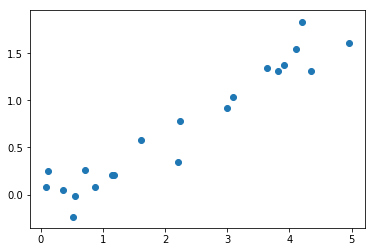

In [15]:
testlog = LogisticRegression(penalty="l2",multi_class="ovr",solver= "saga",max_iter=10000,fit_intercept=False)
testlog.fit(covariates,observed_labels)
plt.scatter(true_coefficients, testlog.coef_[0, :])
plt.show()

In [157]:
niter=1000


with pm.Model() as model:
    alpha = pm.Laplace('alpha', mu=0, b=1)
    beta = pm.Laplace('beta',0,1)

    p = invlogit(alpha + tt.dot(beta,x))
    y_obs = pm.Binomial('y_obs', n=n, p=p, observed=y)

    trace = pm.sample(niter, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:02<00:00, 1444.81draws/s]


In [18]:
nn = 2000
with pm.Model() as testmodel:
    # Weights of the features have a laplace prior which is the same as l1 when minimising the loss function
    beta = pm.Normal('beta', 0.0, sd=3.0, shape=21)
    likelihood = pm.Bernoulli('likelihood', logit_p= tt.dot(covariates,beta) , observed=observed_labels)
    y_obs = pm.Bernoulli("Y_obs",logit_p=y_hat,observed = observed_labels)
    pm.sample(nn,step=pm.NUTS())

MissingInputError: Input 1 of the graph (indices start from 0), used to compute dot(TensorConstant{[[-2.94410..4557e-02]]}, beta), was not provided and not given a value. Use the Theano flag exception_verbosity='high', for more information on this error.

In [135]:
for RV in bay.basic_RVs:
    print(RV.name, RV.logp(bay.test_point))

beta -13.862943611198906
intercept -0.6931471805599453
Y_obs -11895.098765591549


## Random Forrest

In [353]:
def rfr_model(X, y):
# Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RandomForestClassifier(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (500, 1000,2000,3000),
        },
        cv=10, scoring = ["roc_auc","f1_weighted"], verbose=1, n_jobs=2,refit = "roc_auc",return_train_score = False)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    #rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],random_state=False, verbose=False)
# Perform K-Fold CV
    #scores = cross_val_score(rfr, X, y, cv=10, scoring='neg_mean_absolute_error')

    return best_params,grid_result

In [354]:
bestpar,grid =rfr_model(X_train,y_train.bool)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   52.8s
[Parallel(n_jobs=2)]: Done 160 out of 160 | elapsed:  5.4min finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


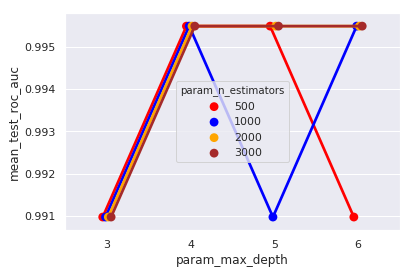

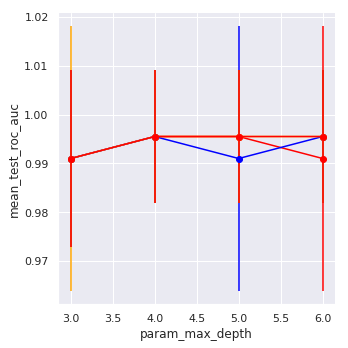

In [357]:
%matplotlib inline
sns.set()
gridpd =pd.DataFrame(grid.cv_results_)
#gridpd.columns
sns.pointplot(x="param_max_depth",y= "mean_test_roc_auc", palette=["red","blue","orange","brown"],hue="param_n_estimators",
             data=gridpd,dodge = True,ci ="sd")
#plt.ylim(0.987,1.001)
#plt.errorbar(data=gridpd,x = "param_max_depth",y= "mean_test_roc_auc",yerr="std_test_roc_auc")
g = sns.FacetGrid(gridpd, palette=["red","blue","orange"],hue="param_n_estimators"
, size=5)
g.map(plt.errorbar, "param_max_depth","mean_test_roc_auc", "std_test_roc_auc", marker="o")

In [213]:
rfr =RandomForestClassifier(max_depth=None, n_estimators=10000,random_state=True, verbose=True)
rfr.fit(X_train,y_train)
rfr.score(X_test,y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:    0.9s finished


0.9393939393939394

Random forest with 10000 trees, max depth set to None and random_state set to True produces an accuracy of 93%, which is equivalent to that of the logistic regression with the saga solver.

In [215]:
rfr.fit(Xn_train,y_train)
rfr.score(Xn_test,y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:    0.7s finished


0.9696969696969697

Using the nmds axis we get an accuracy of 96.7% (which is a single mistake!)

In [204]:
sum(rfr.predict(X_test) == y_test)/y_test.size

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


0.9090909090909091

In [274]:
crossrfr =cross_val_score(rfr,otudf,y=wwfdf.Water,cv=10)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:    5.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurren